# Momentum method 
Presented during ML reading group, 2019-10-29.

Author: Lucian Sasu, lmsasu@unitbv.ro

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


print(f'Numpy version: {np.__version__}')

Numpy version: 1.16.5


## Momentum description

In Stochastic gradient descent, the weight are modified as follows:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} + \Delta \mathbf{w}_{t+1}
$$
where 
$$
\Delta \mathbf{w}_{t+1} = -\eta \nabla_{\mathbf{w}}J(\mathbf{w}_{t})
$$
The momentum method usually accelerates the training process. The momentum method says that the modification of current weights is based not only on the gradient, but also on the previous weights' modification:
$$
\Delta \mathbf{w}_{t+1} = \gamma \Delta \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}}J(\mathbf{w}_{t})
$$
and thus the modification of weights becomes:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} + \Delta \mathbf{w}_{t+1} = \mathbf{w}_{t} + \gamma \Delta \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}}J(\mathbf{w}_{t})
$$

In this way, the search is influenced by the previous direction. It tends to preserve the direction of search and prevents oscillations. In most libraries, $\gamma$ defaults to 0.9. 

## Generate data

Let us generate input 2d data, $(x, y) \in [-scale1, scale1] \times [-scale2, scale2]$, independently and uniformly distributed. The ground truth values associated with a pair $(x, y)$ is $y=a \cdot x + b \cdot y$ (note lack of intercept), to which we add random noise from $\mathcal{N}(0, 1)$.  

In [2]:
np.random.seed(10) # for reproducibility
m = 100
scale1, scale2 = 1, 1 # play with these... 

a, b = 3, 7

def gen_data(m, scale1, scale2, a, b, add_noise=True):
    X = np.random.rand(m, 2) # random values between 0 and 1
    X[:, 0] = X[:, 0] * 2 * scale1 - scale1 # X[0, :] between -scale1 and scale1
    X[:, 1] = X[:, 1] * 2 * scale2 - scale2 # similar
    # generate data of form: a*X[:, 0]+b*X[:, 1] + epsilon, where epsilon comes from Gaussian distribution
    # note that there is no intercept
    y = X @ np.array([a, b])
    if add_noise:
        y += np.random.randn(m)
    y = np.reshape(y, (-1, 1))
    return X, y

In [3]:
X, y = gen_data(m, scale1, scale2, a, b)

3d plot $(X, y)$

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


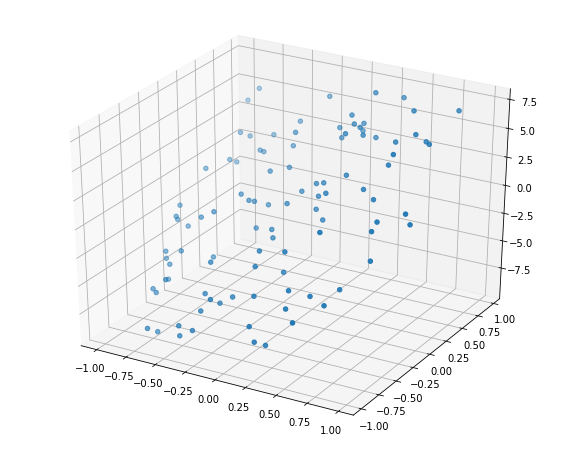

In [4]:
fig = plt.figure(figsize=(10, 8))
# fig, axes = plt.subplots()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, marker='o')
fig.show()

## Define error function, gradient, inference

In [5]:
def model_estimate(X, w):
    return X @ w.reshape(-1, 1)

In [6]:
def J(X, y, w):
    """
    X: input values, of shape n_data x 2
    y: ground truth, column vector
    w: column with 2 components
    """
    w = w.reshape(-1, 1)
    expr = (X@w - y)
    return np.asscalar(1.0/(2 * X.shape[0]) * expr.T @ expr)

In [7]:
J(X, y, w=np.array([3, 7]))

0.394170694191891

In [8]:
# TODO: contour plots of error function

## Vanilla gradient descent

[Cheatsheet](https://medium.com/ml-ai-study-group/vectorized-implementation-of-cost-functions-and-gradient-vectors-linear-regression-and-logistic-31c17bca9181)

![Cheatsheet](https://miro.medium.com/max/1408/1*PZ3TTZZIT1wlqyt05TpZBg.png)

In [9]:
def gradient(X, y, w):
    n = len(y)
    w = w.reshape(-1, 1)
    return 1.0 / n * X.T @ (X@w - y)

In [10]:
gradient(X, y, w=np.array([3, 7]))

array([[ 0.04130157],
       [-0.00722336]])

In [11]:
def gd_no_momentum(X, y, w_init, eta=1e-1):
    eps, maxiter = 1e-3, 1000
    w_init = w_init.reshape(-1, 1)
    lst_errors = [J(X, y, w_init)]
    w_current = w_init
    for i in range(maxiter):
        grad_w = gradient(X, y, w_current)
        w_current = w_current - eta * grad_w
        lst_errors.append(J(X, y, w_current))
        if np.linalg.norm(grad_w) < eps:
            break
    return lst_errors, w_current

In [12]:
w_init = np.array([0, 0])
errors, w_best = gd_no_momentum(X, y, w_init)

In [13]:
print(f'How many iterations were made: {len(errors)}')

How many iterations were made: 248


In [14]:
w_best

array([[2.86265599],
       [7.02578564]])

Text(0.5, 1.0, 'Optimization without momentum')

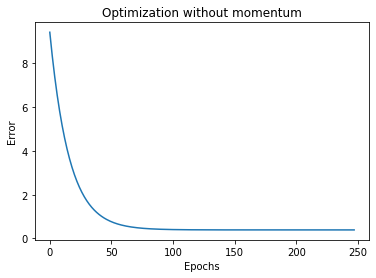

In [15]:
fig, axes = plt.subplots()
axes.plot(list(range(len(errors))), errors)
axes.set_xlabel('Epochs')
axes.set_ylabel('Error')
axes.set_title('Optimization without momentum')

In [16]:
# TODO: show evolution of w on a 2d countour plot 

## Momentum algorithm

In [17]:
def gd_with_momentum(X, y, w_init, eta=1e-1, gamma = 0.9):
    eps, maxiter = 1e-2, 1000
    w_init = w_init.reshape(-1, 1)
    lst_errors = [J(X, y, w_init)]
    
    v = np.zeros_like(w_init)
    w_current = w_init
    for i in range(maxiter):
        grad_w = gradient(X, y, w_current)
        v = gamma * v - eta * grad_w
        w_current = w_current + v
        prev_v = v
        lst_errors.append(J(X, y, w_current))
        if np.linalg.norm(grad_w) < eps:
            break
    return lst_errors, w_current

In [18]:
w_init = np.array([0, 0])
errors_momentum, w_best = gd_with_momentum(X, y, w_init)

In [19]:
print(f'How many iterations were made: {len(errors_momentum)}')

How many iterations were made: 83


In [20]:
w_best

array([[2.87920036],
       [7.01650893]])

Text(0.5, 1.0, 'Optimization with momentum')

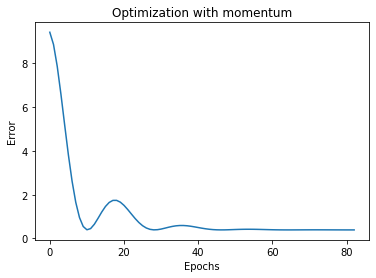

In [21]:
fig, axes = plt.subplots()
axes.plot(list(range(len(errors_momentum))), errors_momentum)
axes.set_xlabel('Epochs')
axes.set_ylabel('Error')
axes.set_title('Optimization with momentum')

In [22]:
# Note: if one plays with scale1, scale2 from above - e.g. scale1=10, scale2=1 - then the results are very interesting....

In [23]:
# TODO: show evolution of w on a 2d countour plot 